# 1. Data Load and Spark Session Settings

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace
import pandas as pd

spark = SparkSession.builder \
    .appName("Apriori with PySpark") \
    .getOrCreate()

file_path = "processed_data (1).csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.show(5)

+-------------------------------+---------------------------------+---------------------------------+--------------+----------------------------------+----------------------------------+---------------------------------+---------------------------------+-------------------+-------------------------+--------------------------------+--------------------------------+
|                          title|                            intro|                         category|     comp_name|                         comp_addr|                              role|                      requirement|                        preferred|                due|               tech_stack|                         welfare|                       procedure|
+-------------------------------+---------------------------------+---------------------------------+--------------+----------------------------------+----------------------------------+---------------------------------+---------------------------------+------------

# 2. Separation of Strings

In [2]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType

df = df.withColumn("category", regexp_replace(col("category"), r"[|/]", " "))
df = df.withColumn("tech_stack", regexp_replace(col("tech_stack"), r"[|/]", " "))

def custom_split(column):
    if not column:
        return []
    if isinstance(column, list):
        column = " ".join(column)
    words = column.split()
    result = []
    i = 0
    while i < len(words):
        if words[i] in ["머신", "인공", "풀"] and i + 1 < len(words):
            # "머신"이나 "인공", "풀"이면 뒤 단어와 결합
            result.append(words[i] + words[i + 1])
            i += 2
        else:
            result.append(words[i])
            i += 1
    return result

custom_split_udf = udf(custom_split, ArrayType(StringType()))

df = df.withColumn("col_2",  custom_split_udf(col("category")))
df = df.withColumn("col_9", custom_split_udf(col("tech_stack")))

category_transactions = (
    df.select("col_2")
    .rdd.flatMap(lambda row: row)
    .filter(lambda x: x is not None)
    .collect()
)

category_transactions_list = [list(set(transaction)) for transaction in category_transactions]

transactions_list = []
for row in df.select("col_2", "col_9").collect():
    col_2_split = row['col_2'] if row['col_2'] is not None else []
    col_9_split = row['col_9'] if row['col_9'] is not None else []

    combined_list = list(set(col_2_split + col_9_split))
    transactions_list.append(combined_list)

print(transactions_list[:15])
print(category_transactions_list[:5])

[['멀티미디어', 'ML', '데이터', '컴퓨터', '머신러닝', '개발자', '파이썬', '비전', '엔지니어'], ['웹', '서버', 'DevOps', '시스템', '개발자', '관리자'], ['웹', 'JavaScript', 'TypeScript', 'React', '서버', 'React.js', 'Node.js', 'Native', '개발자', '프론트엔드'], ['Python', 'CUDA', 'C++', 'DevOps', 'Pytorch', '시스템', '머신러닝', '개발자', '관리자', '파이썬', '엔지니어'], ['웹', '개발자', '소프트웨어', '프론트엔드', '엔지니어'], ['웹', '개발자', '.NET'], ['웹', '개발자', '.NET'], ['웹', '머신러닝', '개발자', '.NET', '엔지니어'], ['서버', '데이터', '개발자', '소프트웨어', '엔지니어'], ['QA,테스트', '엔지니어'], ['Next.js', 'TypeScript', 'React', '개발자', '프론트엔드'], ['웹', '퍼블리셔'], ['JavaScript', 'Veeva', '기술지원', 'Salesforce.com', 'HTML'], ['엔지니어', '머신러닝'], ['Github', 'Python', 'Docker', 'AWS', '데이터', 'Linux', '소프트웨어', '엔지니어', 'Git']]
[['데이터', '머신러닝', '개발자', '파이썬', '엔지니어'], ['웹', '서버', 'DevOps', '시스템', '개발자', '관리자'], ['웹', '서버', '개발자', '프론트엔드'], ['DevOps', '시스템', '머신러닝', '개발자', '관리자', '파이썬', '엔지니어'], ['웹', '개발자', '소프트웨어', '프론트엔드', '엔지니어']]


# 3. Apply the Apriori algorithm






## 3-1.   install mlxtend

---



In [3]:
pip install mlxtend

## 3-2.   Apriori algorithm

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

def get_frequent_itemsets(transactions_list, min_support):
    te = TransactionEncoder()
    te_ary = te.fit(transactions_list).transform(transactions_list)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(te_df, min_support=min_support, use_colnames=True)
    frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda itemset: [item for item in itemset if item.strip()])  # 빈 문자열 제거
    frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 0]

    return frequent_itemsets

#### Print apriori algorithm result

In [5]:
frequent_itemsets = get_frequent_itemsets(transactions_list,0.033) # 그래프로 구한 supoort는 0.033
print(frequent_itemsets)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      support                            itemsets
0    0.044118                              [.NET]
1    0.067647                                [AI]
2    0.047059                               [API]
3    0.088235                               [AWS]
4    0.038235                           [Android]
..        ...                                 ...
264  0.050000            [C++, 솔루션, C, Linux, SW]
265  0.035294        [Python, C++, C, 머신러닝, 인공지능]
266  0.038235       [Embedded, 솔루션, C, Linux, SW]
267  0.035294     [C++, Embedded, 솔루션, Linux, SW]
268  0.035294  [C++, Embedded, 솔루션, C, Linux, SW]

[269 rows x 2 columns]


## 3-3. Create association rules

## 3-3-1. category 향한 연관도

In [ ]:
from itertools import combinations
import pandas as pd

def manual_association_rules(frequent_itemsets, category_transactions_list, min_confidence=0.21, min_lift=2.6):
    rules = []

    category_transactions_set = set(frozenset(transaction) for transaction in category_transactions_list)
    frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(frozenset)

    for i, row in frequent_itemsets.iterrows():
        itemset = frozenset(row['itemsets'])
        support = row['support']

        for n in range(1, len(itemset)):
            for antecedent in combinations(itemset, n):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent

                if consequent in category_transactions_set:
                    if len(consequent) > 0:
                        # antecedent와 전체 아이템셋의 support 계산
                        antecedent_support = frequent_itemsets[frequent_itemsets['itemsets'] == antecedent][
                            'support'].values
                        if len(antecedent_support) == 0:
                            antecedent_support = 0
                        else:
                            antecedent_support = antecedent_support[0]

                        # confidence 및 lift 계산
                        confidence = support / antecedent_support if antecedent_support > 0 else 0
                        consequent_support = frequent_itemsets[frequent_itemsets['itemsets'] == consequent][
                            'support'].values
                        if len(consequent_support) == 0:
                            consequent_support = 0
                        else:
                            consequent_support = consequent_support[0]
                        lift = confidence / consequent_support if consequent_support > 0 else 0

                        if confidence >= min_confidence and lift >= min_lift:
                            rules.append({
                                'antecedent': antecedent,
                                'consequent': consequent,
                                'support': support,
                                'confidence': confidence,
                                'lift': lift
                            })

    return pd.DataFrame(rules)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Print association rule

In [ ]:
from tabulate import tabulate

rules_df = manual_association_rules(frequent_itemsets, category_transactions_list)
rules_df['antecedent'] = rules_df['antecedent'].apply(lambda x: ', '.join(x))
rules_df['consequent'] = rules_df['consequent'].apply(lambda x: ', '.join(x))

def adjust_consequent_spacing(antecedent_text, consequent_text, width, padding=2):
    cleaned_antecedent = ''.join([char for char in antecedent_text if char not in [',', '+','.','#'," "]])

    if all('a' <= char.lower() <= 'z' for char in cleaned_antecedent):  # 영어만 포함된 경우
        consequent_text = "  " + consequent_text  # 공백 두 개 추가

    return f"{consequent_text:<{width}}"

header_widths = {
    "antecedent": 30,
    "consequent": 25,
    "support": 15,
    "confidence": 15,
    "lift": 15
}

header = (
    f"{'Antecedent':<{header_widths['antecedent']}}"
    f"{'Consequent':<{header_widths['consequent']}}"
    f"{'Support':<{header_widths['support']}}"
    f"{'Confidence':<{header_widths['confidence']}}"
    f"{'Lift':<{header_widths['lift']}}"
)
line_separator = "-" * len(header)

print(header)
print(line_separator)

for _, row in rules_df.iterrows():
    antecedent = f"{''.join(row['antecedent']):<{header_widths['antecedent']}}"

    # Consequent에서 antecedent에 영어만 포함된 경우, 공백 두 개 추가
    consequent = adjust_consequent_spacing(row['antecedent'], row['consequent'], header_widths['consequent'])

    support = f"{row['support']:.2f}".ljust(header_widths['support'] - 2)
    confidence = f"{row['confidence']:.2f}".ljust(header_widths['confidence'] - 2)
    lift = f"{row['lift']:.2f}".ljust(header_widths['lift'] - 2)

    print(f"{antecedent}{consequent}{support}{confidence}{lift}")

Antecedent                    Consequent               Support        Confidence     Lift           
----------------------------------------------------------------------------------------------------
AI                              머신러닝                   0.05         0.70         4.38         
DeepLearning                    머신러닝                   0.04         0.93         5.85         
JavaScript                      프론트엔드                  0.05         0.38         3.70         
PyTorch                         머신러닝                   0.05         0.81         5.10         
React                           프론트엔드                  0.04         0.70         6.80         
인공지능                          머신러닝                     0.10         0.83         5.19         
Python, AI                      머신러닝                   0.04         0.86         5.40         
AI                              머신러닝, 인공지능             0.05         0.70         7.17         
AI, 인공지능                      머신러닝    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4. Get proper support and confidence

## 4-1. find proper support


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def calculate_itemset_counts(transactions_list, start=0.01, stop=0.25, step=0.001):
    min_support_values = [start + i * step for i in range(int((stop - start) / step))]
    itemset_counts = []

    for support in min_support_values:
        frequent_itemsets = get_frequent_itemsets(transactions_list, support)
        itemset_counts.append(len(frequent_itemsets))

    return min_support_values, itemset_counts


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


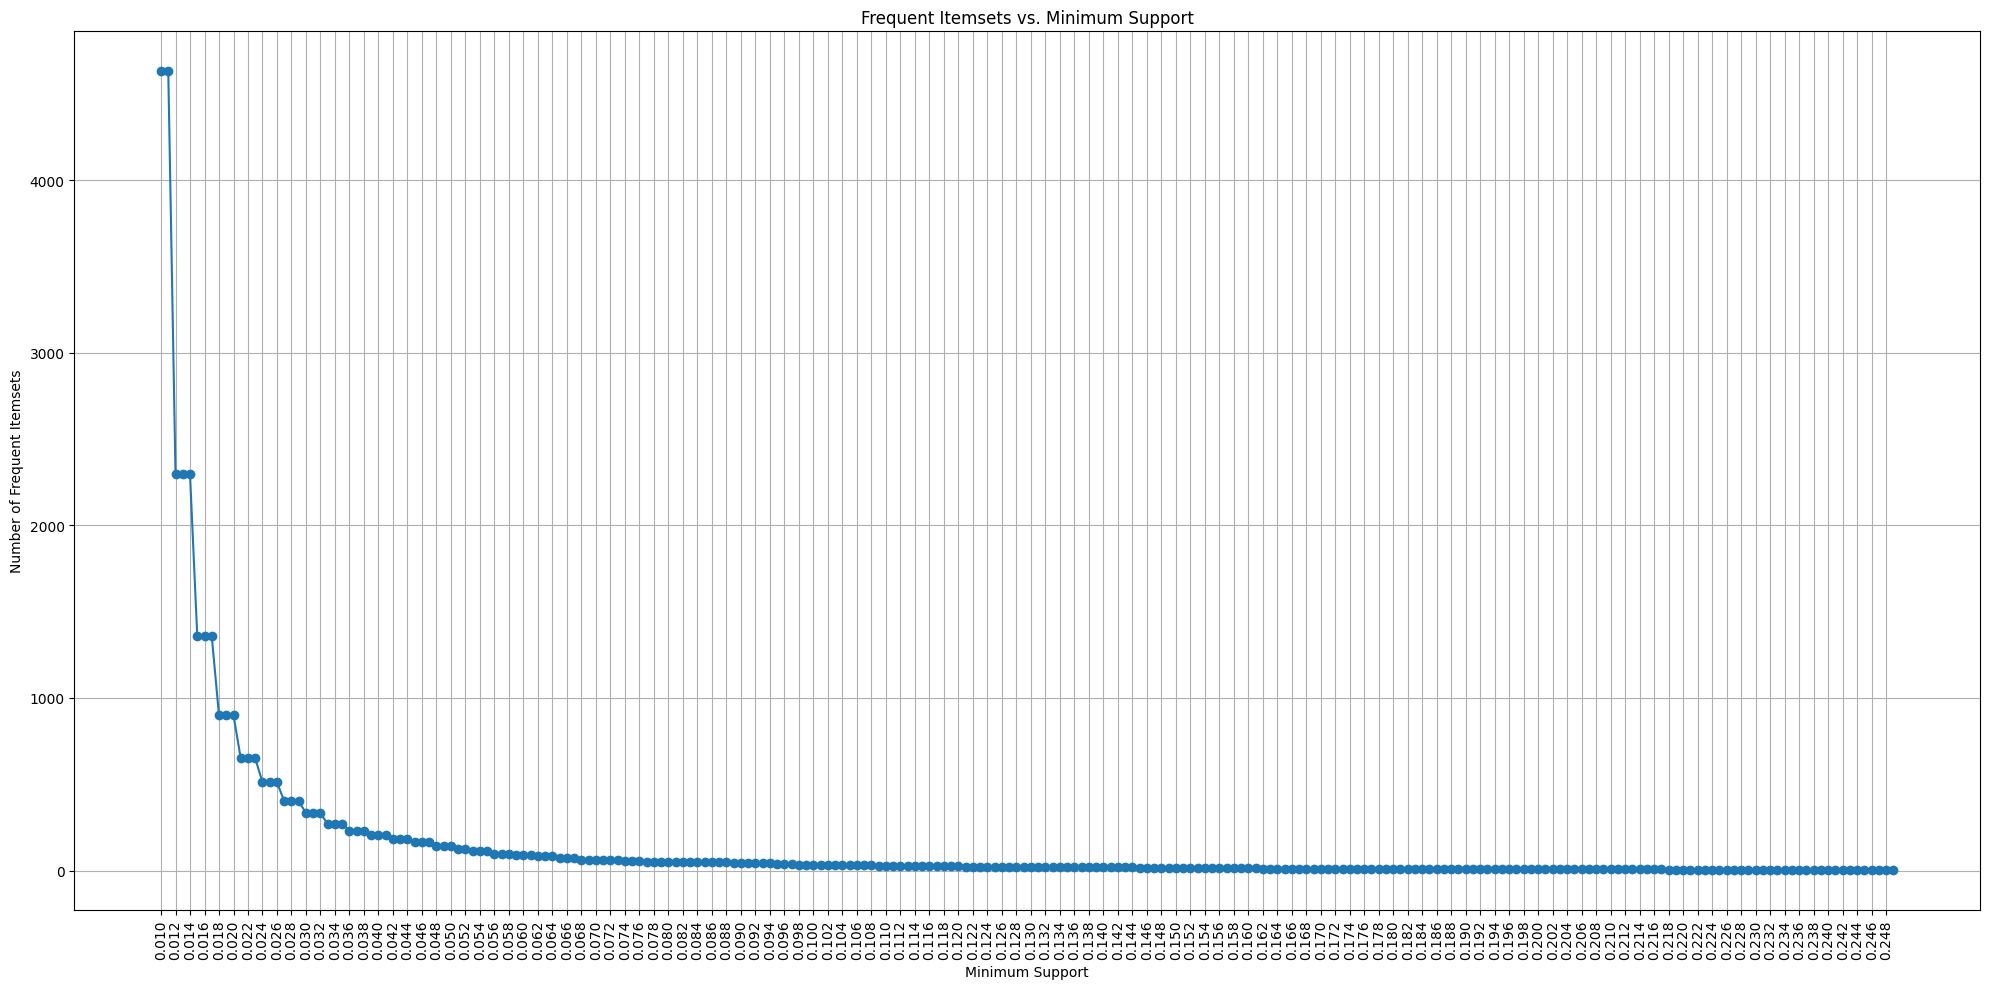

In [ ]:
min_support_values, itemset_counts = calculate_itemset_counts(transactions_list)
plt.figure(figsize=(20, 10))
plt.plot(min_support_values, itemset_counts, marker='o')
plt.xlabel('Minimum Support')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Frequent Itemsets vs. Minimum Support')

plt.xticks(min_support_values[::2], rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Elbow point found at min_support = 0.033, frequent itemsets = 269.000


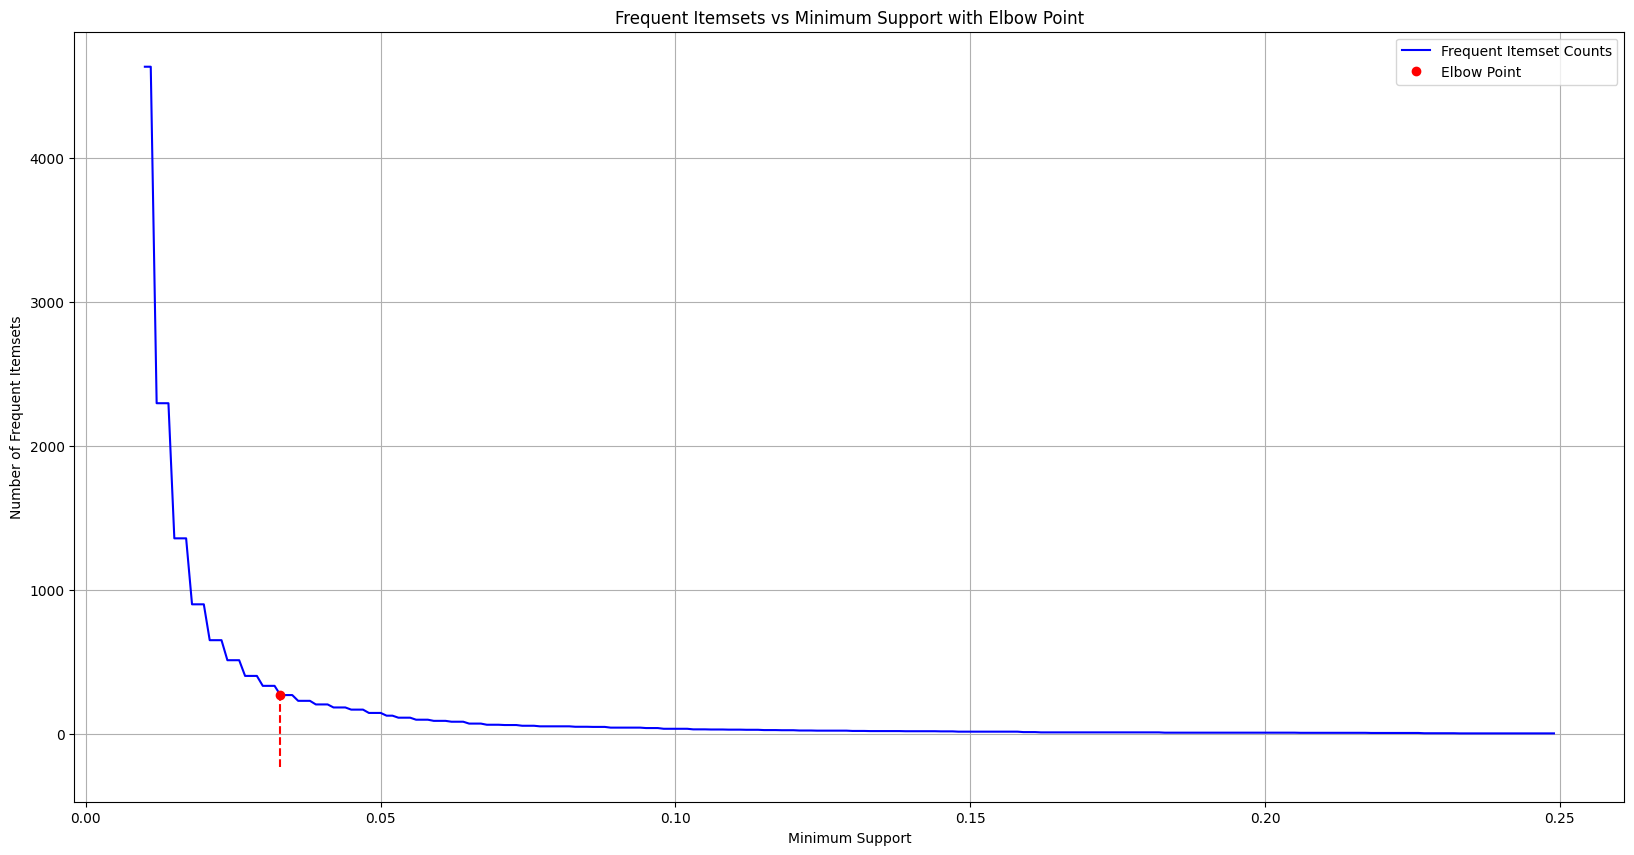

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

def find_elbow(x, y):
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])

    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        distance = np.abs(np.cross(end - start, start - point) / np.linalg.norm(end - start))
        distances.append(distance)

    max_idx = np.argmax(distances)
    return x[max_idx], y[max_idx], max_idx

min_support_values, itemset_counts = calculate_itemset_counts(transactions_list)

elbow_x, elbow_y, idx = find_elbow(min_support_values, itemset_counts)

plt.figure(figsize=(20, 10))
plt.plot(min_support_values, itemset_counts, 'b-', label='Frequent Itemset Counts')
plt.plot(elbow_x, elbow_y, 'ro', label='Elbow Point')
plt.vlines(elbow_x, plt.ylim()[0], elbow_y, linestyles='dashed', colors='r')

plt.xlabel('Minimum Support')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Frequent Itemsets vs Minimum Support with Elbow Point')
plt.legend()
plt.grid(True)

print(f"Elbow point found at min_support = {elbow_x:.3f}, frequent itemsets = {elbow_y:.3f}")
plt.show()


## 4-2. find proper confidence

In [ ]:
confidence_values = [0.05 + 0.02 * i for i in range(50)]
lift_values = [1.0 + 0.2 * i for i in range(50)]

def calculate_rule_counts_combined(frequent_itemsets, category_transactions_list, confidence_values, lift_values):
    results = []

    for confidence in confidence_values:
        for lift in lift_values:
            rules = manual_association_rules(frequent_itemsets, category_transactions_list,
                                             min_confidence=confidence, min_lift=lift)
            results.append({
                'confidence': confidence,
                'lift': lift,
                'rule_count': len(rules)
            })

    results_df = pd.DataFrame(results)
    return results_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


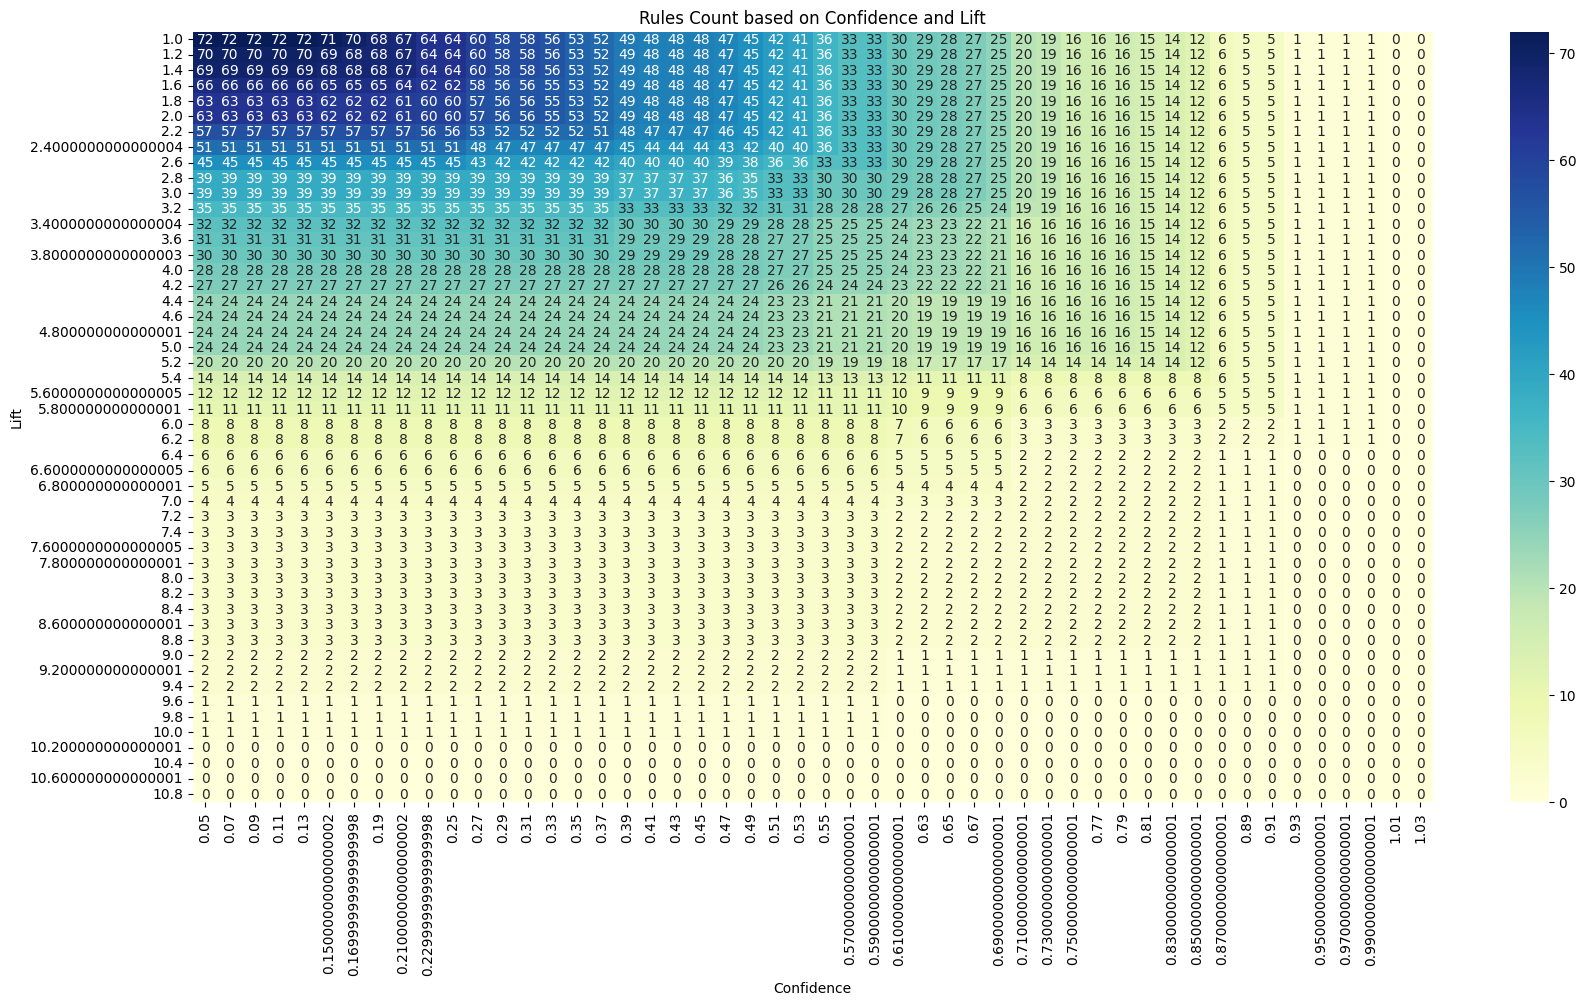

Elbow Confidence: 0.21000000000000002, Elbow Lift: 2.6


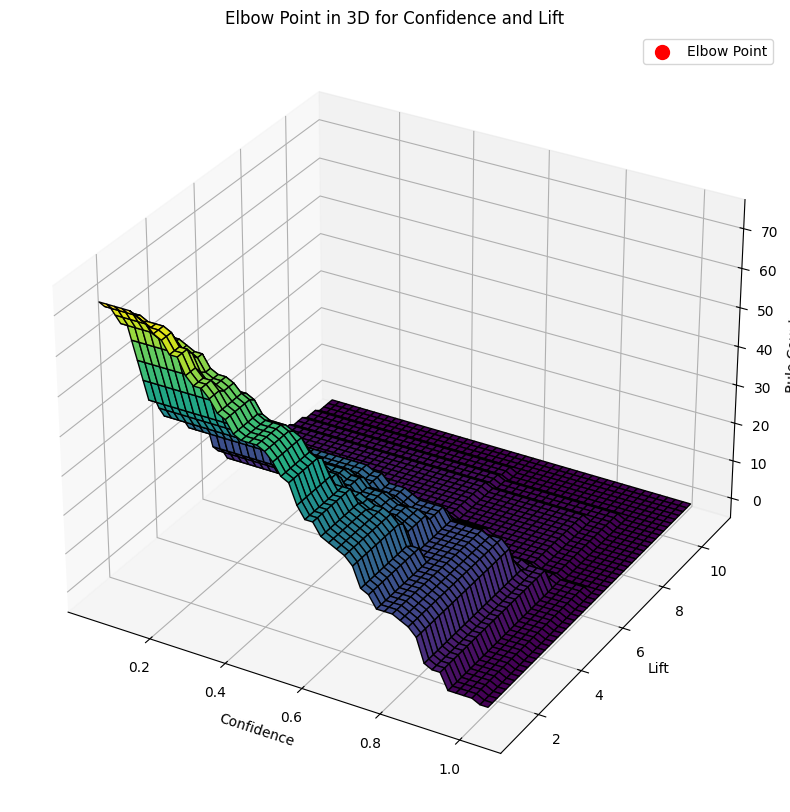

In [ ]:
import seaborn as sns

results_df = calculate_rule_counts_combined(frequent_itemsets, category_transactions_list,
                                            confidence_values, lift_values)

heatmap_data = results_df.pivot(index='lift', columns='confidence', values='rule_count')

valid_lift_values = results_df['lift'].unique()[:50]
valid_confidence_values = results_df['confidence'].unique()[:50]

plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Rules Count based on Confidence and Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.show()

rule_counts = heatmap_data.values

diff_confidence = np.diff(rule_counts, axis=1)  # Confidence에 대한 변화
diff_lift = np.diff(rule_counts, axis=0)  # Lift에 대한 변화
change_confidence = np.abs(diff_confidence)
change_lift = np.abs(diff_lift)

# 두 변화량의 크기를 합산하여 급격한 변화 포착
combined_changes = np.abs(np.diff(change_confidence.sum(axis=1))) + np.abs(np.diff(change_lift.sum(axis=0)))

# 변화가 급격히 감소하는 지점 찾기
elbow_confidence_idx = np.argmax(combined_changes)
elbow_lift_idx = np.argmax(combined_changes)

elbow_confidence = valid_confidence_values[elbow_confidence_idx]
elbow_lift = valid_lift_values[elbow_lift_idx]
print(f"Elbow Confidence: {elbow_confidence}, Elbow Lift: {elbow_lift}")

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

conf, lift = np.meshgrid(valid_confidence_values, valid_lift_values)

ax.plot_surface(conf, lift, rule_counts, cmap="viridis", edgecolor='k')

elbow_z_value = rule_counts[elbow_lift_idx, elbow_confidence_idx]

ax.scatter(elbow_confidence, elbow_lift, elbow_z_value,
           color='r', s=100, label='Elbow Point')

ax.set_xlabel("Confidence")
ax.set_ylabel("Lift")
ax.set_zlabel("Rule Count")
ax.legend()

plt.title("Elbow Point in 3D for Confidence and Lift")
plt.show()


# Analyzing the performance of the Apriori algorithm

##  FP-Growth Algorithm

In [6]:
import time
from mlxtend.frequent_patterns import apriori, fpgrowth

def get_frequent_itemsets_fpgrowth(transactions_list, min_support):
    te = TransactionEncoder()
    te_ary = te.fit(transactions_list).transform(transactions_list)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(te_df, min_support=min_support, use_colnames=True)
    frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda itemset: [item for item in itemset if item.strip()])  # 빈 문자열 제거
    frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 0]

    return frequent_itemsets

frequent_itemsets = get_frequent_itemsets_fpgrowth(transactions_list,0.033) # 그래프로 구한 supoort는 0.033
print(frequent_itemsets)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      support                    itemsets
0    0.232353                       [개발자]
1    0.158824                      [머신러닝]
2    0.144118                      [엔지니어]
3    0.035294                       [데이터]
4    0.182353                        [서버]
..        ...                         ...
264  0.035294    [인공지능, 머신러닝, AI, Python]
265  0.035294             [인공지능, C++, AI]
266  0.041176        [DeepLearning, 인공지능]
267  0.038235        [DeepLearning, 머신러닝]
268  0.038235  [DeepLearning, 머신러닝, 인공지능]

[269 rows x 2 columns]


## Analyzing the performance



In [10]:
# 성능 측정: Apriori
start_time = time.time()
apriori_results = get_frequent_itemsets(transactions_list, 0.033)
apriori_time = time.time() - start_time

# 성능 측정: FP-Growth
start_time = time.time()
fpgrowth_results = get_frequent_itemsets_fpgrowth(transactions_list, 0.033)
fpgrowth_time = time.time() - start_time

# 결과 출력
print(f"Apriori Results:\n{apriori_results}\n")
print(f"FP-Growth Results:\n{fpgrowth_results}\n")

print(f"Apriori Execution Time: {apriori_time:.6f} seconds")
print(f"FP-Growth Execution Time: {fpgrowth_time:.6f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Apriori Results:
      support                            itemsets
0    0.044118                              [.NET]
1    0.067647                                [AI]
2    0.047059                               [API]
3    0.088235                               [AWS]
4    0.038235                           [Android]
..        ...                                 ...
264  0.050000            [C++, 솔루션, C, Linux, SW]
265  0.035294        [Python, C++, C, 머신러닝, 인공지능]
266  0.038235       [Embedded, 솔루션, C, Linux, SW]
267  0.035294     [C++, Embedded, 솔루션, Linux, SW]
268  0.035294  [C++, Embedded, 솔루션, C, Linux, SW]

[269 rows x 2 columns]

FP-Growth Results:
      support                    itemsets
0    0.232353                       [개발자]
1    0.158824                      [머신러닝]
2    0.144118                      [엔지니어]
3    0.035294                       [데이터]
4    0.182353                        [서버]
..        ...                         ...
264  0.035294    [인공지능, 머신러닝, AI, Python]
265